In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import kagglehub

# Download latest version
path = kagglehub.dataset_download("ammarsayedtaha/arabic-sign-language-dataset-2022")

print("Path to dataset files:", path)

print('Data source import complete.')

100%|██████████| 808M/808M [00:08<00:00, 95.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ammarsayedtaha/arabic-sign-language-dataset-2022/versions/2
Data source import complete.


In [ ]:
import os
print(os.listdir( '/root/.cache/kagglehub/datasets/ammarsayedtaha/arabic-sign-language-dataset-2022/versions/2/datasets'))

['sign.yaml', 'valid', 'val.txt', 'train.cache', 'train', 'train.cache.npy', 'train.txt']


In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 12.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled 

In [ ]:
#--------------------Importing Needed Libraries----------------------
import os
import cv2
import tensorflow as tf
import numpy as np
import mediapipe as mp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [ ]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(                                        # needed for creating hand model for detecting its landmarks
    static_image_mode=True,                                    # we have static images for creating the model
    max_num_hands=1,                                           # to detect one hand maximum at once
    min_detection_confidence=0.5,                              # confidence threshold for detection
    min_tracking_confidence=0.5                                # confidence threshold for tracking
)

def extract_keypoints(image_path):
    """from one hand , we should extract 21 value for (x,y) pair , that means we should extract all 42 values"""
    image = cv2.imread(image_path) #Read images for Extracting keypoints as BGR
    if image is None:
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #converting to RGB for allowing mediapipe working properly
    results = hands.process(image_rgb)                 #Getting a Landmarks results

    if results.multi_hand_landmarks:
        """Detecting just one hands first clear hand to extract features"""
        hand_lms = results.multi_hand_landmarks[0]
        keypoints = []
        for lm in hand_lms.landmark:
            keypoints.extend([lm.x, lm.y]) # resulting (x,y) pair landmarks
        return np.array(keypoints)

    return np.zeros(42) # if no hand detected , return zeros

# -------------------------------
# 2. Load dataset and extract keypoints
# -------------------------------
DATASET_PATH = "/root/.cache/kagglehub/datasets/ammarsayedtaha/arabic-sign-language-dataset-2022/versions/2/datasets"  # غيّر المسار لو مختلف

def load_data_and_extract_keypoints():
    X = []
    y = []

    for split in ["train", "valid"]:
        print(f"Processing {split}...")
        img_folder = os.path.join(DATASET_PATH, split, "images")
        label_folder = os.path.join(DATASET_PATH, split, "labels")

        for img_name in tqdm(os.listdir(img_folder)):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(img_folder, img_name)
            txt_path = os.path.join(label_folder, img_name.rsplit('.', 1)[0] + '.txt')

            # read the class of letter form label file
            if os.path.exists(txt_path):
                with open(txt_path, 'r') as f:
                    first_line = f.readline().strip()
                    if first_line:
                        class_id = int(first_line.split()[0])
                    else:
                        continue
            else:
                continue


            kps = extract_keypoints(img_path)  #Extracting the keypoints
            if kps is not None:
                X.append(kps)                # keypoints is input
                y.append(class_id)           # class is output

    return np.array(X), np.array(y)

X, y = load_data_and_extract_keypoints()

print(f"{len(X)} was processed properly ")
print(f"number_of_classes", len(np.unique(y)))


Processing train...


100%|██████████| 9955/9955 [04:54<00:00, 33.85it/s]


Processing valid...


100%|██████████| 4247/4247 [02:07<00:00, 33.23it/s]

14202 was processed properly 
number_of_classes 32


In [ ]:
le = LabelEncoder()                              # Create a new LabelEncoder instance to map class labels to integers.
y_cat = le.classes_ = np.unique(y)               # Force-set the encoder's classes to the sorted unique labels from y (NOT recommended; see note).
y_encoded = le.transform(y)                      # Transform the original labels y into encoded integer indices using the encoder.
y_categorical = to_categorical(y_encoded)        # Convert integer labels to one-hot vectors for categorical cross-entropy training.

# Split the dataset into training and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)  # Stratify ensures class distribution is preserved between splits.

# Reshape inputs for Conv1D: (samples, timesteps, channels)
X_train = X_train.reshape(-1, 42, 1)             # Reshape training features to (num_samples, 42 timesteps, 1 channel) expected by Conv1D.
X_test = X_test.reshape(-1, 42, 1)               # Reshape test features similarly.

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)

X_train: (11361, 42, 1)
X_test: (2841, 42, 1)
y_train: (11361, 32)


In [ ]:
model = Sequential([                                    # Create a Sequential model (stacked layers).
    Conv1D(128, kernel_size=3, activation='relu',
           input_shape=(42, 1), padding='same'),        # 1st Conv1D layer: extract local  patterns from keypoints.

    BatchNormalization(),                               # Normalize activations to stabilize and speed up training.

    Conv1D(256, kernel_size=3, activation='relu',       # Relu Activition funcation prevents vanshing gradient, turn all negatives to zeros , learn on non-linearity
           padding='same'),
    BatchNormalization(),

    Conv1D(512, kernel_size=3, activation='relu',
           padding='same'),
    BatchNormalization(),

    Conv1D(512, kernel_size=3, activation='relu',
           padding='same'),
    BatchNormalization(),                               .

    GlobalAveragePooling1D(),                           # Convert sequence features into a single vector by averaging over time.

    Dense(1024, activation='relu'),                     # Fully-connected layer for high-level representation.
    Dropout(0.5),                                       # Dropout to prevent overfitting and More regularization.

    Dense(512, activation='relu'),                      # Another dense layer for deeper learning.
    Dropout(0.4),

    Dense(256, activation='relu'),                      # Smaller dense layer to compress learned representation.
    Dropout(0.3),

    Dense(len(le.classes_), activation='softmax')       # Output layer: one neuron per class with softmax for classification.
], name="Arabic_Sign_Language_CNN1D")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),   # Use Adam optimizer with LR=0.001.
    loss='categorical_crossentropy',                           # Use categorical crossentropy for multi-class classification.
    metrics=['accuracy']                                       # Track accuracy during training.
)

model.summary()                                                # Print full model architecture and parameter counts.

# -------------------------------
# 6. Callbacks
# -------------------------------
early = EarlyStopping(monitor='val_accuracy',
                      patience=10,                               # wait 10 epochs with no improvement
                      restore_best_weights=True,                 # revert to the best model weights
                      verbose=1)                                # Stop training early if validation accuracy stops improving.

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=5,                       # wait 5 epochs with no improvement
                              verbose=1)                        # Reduce LR by 50% if validation accuracy plateaus.

# -------------------------------
# 7. Training
# -------------------------------
history = model.fit(
    X_train, y_train,                                          # Training data.
    epochs=200,                                                # Max number of training epochs.
    batch_size=128,                                            # Number of samples per batch.
    validation_data=(X_test, y_test),                          # Use test set for validation during training.
    callbacks=[early, reduce_lr],                              # Apply EarlyStopping + LR scheduler.
    verbose=1                                                  # Print training progress.
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Arabic_Sign_Language_CNN1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 42, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 42, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 42, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 42, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 42, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 42, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 42, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 42, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         8,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,475,040 (9.44 MB)

 Trainable params: 2,472,224 (9.43 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - accuracy: 0.0400 - loss: 3.5528 - val_accuracy: 0.0313 - val_loss: 3.4885 - learning_rate: 0.0010
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0738 - loss: 3.2587 - val_accuracy: 0.0338 - val_loss: 4.2005 - learning_rate: 0.0010
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2419 - loss: 2.3260 - val_accuracy: 0.0401 - val_loss: 6.1099 - learning_rate: 0.0010
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4573 - loss: 1.5332 - val_accuracy: 0.0507 - val_loss: 7.4968 - learning_rate: 0.0010
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5485 - loss: 1.3040 - val_accuracy: 0.0803 - val_loss: 3.6471 - learning_rate: 0.0010
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6819 - loss: 0.9077 - val_accuracy: 0.2306 - val_loss: 2.7644 - learning_rate: 0.0010
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7568 - loss: 0.7356 

Final accuarcy 93.171%
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


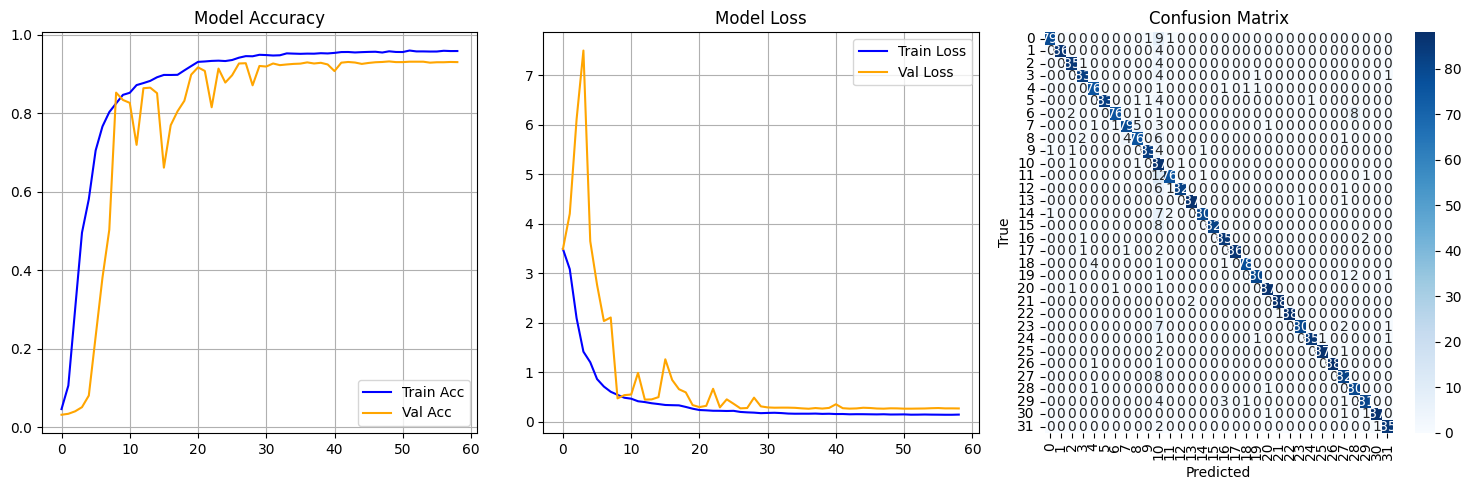

              precision    recall  f1-score   support

           0       0.98      0.88      0.92        90
           1       1.00      0.96      0.98        90
           2       0.94      0.94      0.94        90
           3       0.94      0.93      0.94        89
           4       0.92      0.95      0.93        80
           5       1.00      0.92      0.96        90
           6       0.97      0.86      0.92        88
           7       0.94      0.88      0.91        90
           8       0.90      0.85      0.88        89
           9       0.98      0.92      0.95        90
          10       0.46      0.97      0.62        90
          11       0.95      0.84      0.89        90
          12       0.99      0.91      0.95        90
          13       0.98      0.98      0.98        89
          14       0.98      0.89      0.93        90
          15       1.00      0.91      0.95        90
          16       0.94      0.97      0.96        88
          17       1.00    

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Final accuarcy {test_acc*100:.3f}%")

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(history.history['accuracy'], label='Train Acc', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Acc', color='orange')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

plt.subplot(1,3,3)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=[str(c) for c in le.classes_]))


In [ ]:
model.save("Arabic_Sign_Language_CNN1D.h5")

In [ ]:
from google.colab import files
files.download("Arabic_Sign_Language_CNN1D.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>